In [88]:
import matplotlib
matplotlib.use('TkAgg')

import requests
import urllib.request
import keras
import sklearn
import sklearn.cross_validation
import os
import cv2

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

/Users/peekabuy/projects/detect_clothes/env/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# import data
r = requests.get('https://test.flaunt.peekabuy.com/api/board/get_jc_product_images_batch/?page=3')

In [7]:
image_urls = r.json()['images']

In [15]:
data_dir = Path('../data/raw')

for url in image_urls:
    splits = url.split('/')
    filename = splits[-1]
    filepath = data_dir / filename
    urllib.request.urlretrieve(url, str(filepath))
    

../data/4fbedb7bf74ebea3381a5f94ef413eac.jpg
../data/661f7f5b758dad38ac6fdf3922c648e4.jpg
../data/97db99ef15d57e2779b6798462023659.jpg
../data/186d262630df3cbd68012ab89ba71e35.jpg
../data/92c8032a9a040ad2c68dff2918f458e6.jpg
../data/a0699e1cac5faf222ce1e8009ffae59a.jpg
../data/5e52345a3a1fe6709eb5de229b13479c.jpg
../data/a0e0ee65222834586338f17ce10e87eb.jpg
../data/a6d379e60044ee743d47e6eabe35386d.jpg
../data/80e77b7aab508f91862a11d0edd89bbc.jpg
../data/748c6281ba693ed4f3ecc486d017dd50.jpg
../data/93ba72bc36d1c2e0efd15fd21e910d32.jpg
../data/530bcb6c7858f32df07301728ae49da1.jpg
../data/f3ffb4577141d62aeb3709e6e6424c45.jpg
../data/3d7276af693af671a3d5a2f3cc06bc0e.jpg
../data/6165f54a8c68de1dad78db2a79e96c63.jpg
../data/0c6fe551acc18ac002b3e8084048743c.jpg
../data/7c2e0159e68207a35a8ff69238cf63ae.jpg
../data/5664037d3669fbcb93aee4d03942e3dd.jpg
../data/39bf523d1eb84d6ece22e481cc32edc3.jpg
../data/f121e9ac236e0e12b515b8e0d4b3de62.jpg
../data/5b6191cd14ac7a09f5b924a72958d91c.jpg
../data/a5

- Do dresses with shirts count as one thing or two things
    - try treating as one piece
- Should clothes with people in them be rejected
    - 
- Should clothes with weird backgrounds (i.e. white on white) be rejected also
    - classify them out
    
    
Do fine-grained annotation but try bucketing / not bucketing the labels

There's a list of labels that should be fed through the existing cropping pipeline and a list that need to be further examined

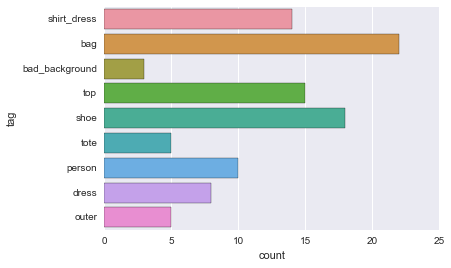

In [56]:
gt_labels = pd.read_csv('../data/raw.csv', header=None, names=['image_name', 'tag'])

sns.countplot(data=gt_labels, y='tag')

num_classes = len(gt_labels.tag.unique())

In [50]:
# fine-grained first pass

# create directory of symlinks
data_path = Path('../data')
train_finegrain_dir = data_path / 'train_finegrain'
test_finegrain_dir = data_path / 'test_finegrain'
if not train_finegrain_dir.exists():
    train_finegrain_dir.mkdir()
    
if not test_finegrain_dir.exists():
    test_finegrain_dir.mkdir()

# generate stratified split
X = gt_labels.image_name
y = gt_labels.tag

X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.1, stratify=y)

# symlink train data
for im_name, label in zip(X_train, y_train):
    source_path = (data_path / 'raw' /im_name).resolve()
    dest_path = train_finegrain_dir / label / im_name
    
    class_dir = dest_path.parent
    
    if not class_dir.exists():
        class_dir.mkdir()
    
    if dest_path.exists():
        continue
    
    os.symlink(str(source_path), str(dest_path))
    
# symlink test data
for im_name, label in zip(X_test, y_test):
    source_path = (data_path / 'raw' /im_name).resolve()
    dest_path = test_finegrain_dir / label / im_name
    
    class_dir = dest_path.parent
    
    if not class_dir.exists():
        class_dir.mkdir()
    
    if dest_path.exists():
        continue
    
    os.symlink(str(source_path), str(dest_path))


In [60]:
# train / test generators
train_data_dir = str(train_finegrain_dir)
validation_data_dir = str(test_finegrain_dir)

img_height = 224
img_width = 224

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical')




Found 100 images belonging to 9 classes.
Found 10 images belonging to 9 classes.


In [62]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, 224, 224)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [63]:
model.fit_generator(
        train_generator,
        samples_per_epoch=2000,
        nb_epoch=50,
        validation_data=validation_generator,
        nb_val_samples=800)
model.save_weights('finegrained.h5')

Epoch 1/50
 836/2000 [===========>..................] - ETA: 172s - loss: 2.1517 - acc: 0.2368

KeyboardInterrupt: 

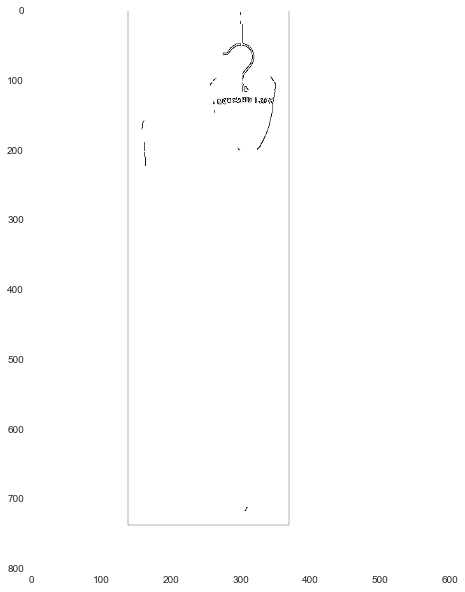

In [106]:
# simple bounding box doer
test_image_filename = '7c2e0159e68207a35a8ff69238cf63ae.jpg'
test_image_path = (Path('../data/raw') / test_image_filename).resolve()

test_image = cv2.imread(str(test_image_path))
gray_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
 
    # return the edged image
    return edged

edges = auto_canny(gray_image)


fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111, aspect='equal')
ax1.imshow(edges)

box = cv2.boundingRect(edges)

pad = 20

ax1.add_patch(
    patches.Rectangle(
        (box[0] - pad, box[1] - pad),   # (x,y)
        box[2] + 2*pad,          # width
        box[3] + 2*pad,          # height
        fill=False
    )
)

# im2, contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# plt.figure(figsize=(10,10))
# plt.imshow(im2)

In [163]:
test_images = list(Path('../data/raw').glob('*.jpg'))
out_dir = Path('../data/simpleboxes')

if not out_dir.exists():
    out_dir.mkdir()
    
pad = 5
    
boxes = {}
for image_path in test_images:
    key = image_path.parts[-1]
    test_image = cv2.imread(str(image_path))
    gray_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

    edges = auto_canny(gray_image)
    
    x, y, w, h = cv2.boundingRect(edges)
    
    # draw on the image and then save it to the output place
    
    
    x1 = np.clip(x - pad, 0, None)
    y1 = np.clip(y - pad, 0, None)
    x2 = np.clip(x + w + pad, None, test_image.shape[1])
    y2 = np.clip(y + h + pad, None, test_image.shape[0])
    
    
    cv2.rectangle(test_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    cv2.imwrite(str(out_dir / key), test_image)
